In [1]:
!pip install kaggle


In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [02:04<00:00, 18.8MB/s]
100% 2.29G/2.29G [02:04<00:00, 19.8MB/s]


In [6]:
#Unzip the downloaded data
import zipfile
zip_ref = zipfile.ZipFile("/content/chest-xray-pneumonia.zip","r")
zip_ref.extractall()
zip_ref.close()

In [7]:
# Lets look at that how many images are in each folder
import os
for dirpath, dirnames, filenames in os.walk("chest_xray"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 5 directories and 0 images in 'chest_xray'.
There are 1 directories and 1 images in 'chest_xray/__MACOSX'.
There are 3 directories and 3 images in 'chest_xray/__MACOSX/chest_xray'.
There are 2 directories and 3 images in 'chest_xray/__MACOSX/chest_xray/train'.
There are 0 directories and 3876 images in 'chest_xray/__MACOSX/chest_xray/train/PNEUMONIA'.
There are 0 directories and 1342 images in 'chest_xray/__MACOSX/chest_xray/train/NORMAL'.
There are 2 directories and 3 images in 'chest_xray/__MACOSX/chest_xray/test'.
There are 0 directories and 390 images in 'chest_xray/__MACOSX/chest_xray/test/PNEUMONIA'.
There are 0 directories and 234 images in 'chest_xray/__MACOSX/chest_xray/test/NORMAL'.
There are 2 directories and 1 images in 'chest_xray/__MACOSX/chest_xray/val'.
There are 0 directories and 9 images in 'chest_xray/__MACOSX/chest_xray/val/PNEUMONIA'.
There are 0 directories and 9 images in 'chest_xray/__MACOSX/chest_xray/val/NORMAL'.
There are 3 directories and 1 images 

We have lots of files in this dataset. But I am gonna focus on chest_xray files.

In [57]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
def view_random_image(target_dir, target_class):
  target_folder= target_dir+target_class
  random_image=random.sample(os.listdir(target_folder),1)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")
  return img

Image shape: (1008, 1480)


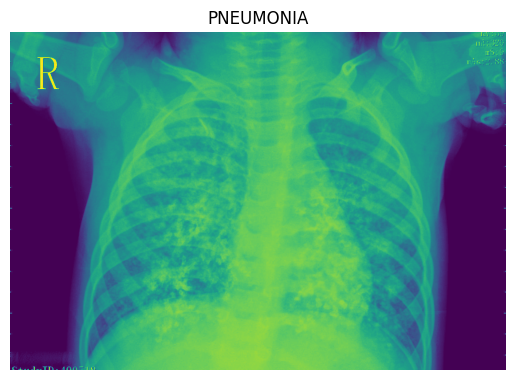

In [66]:
img=view_random_image(target_dir="/content/chest_xray/chest_xray/train/", target_class="PNEUMONIA")

In [68]:
img

array([[119, 122, 126, ..., 150, 144, 130],
       [121, 124, 127, ..., 147, 146, 141],
       [123, 125, 128, ..., 139, 127, 139],
       ...,
       [ 10,   8,   0, ...,   0,   0,   0],
       [  0,   1,  13, ...,   0,   0,   0],
       [  0,   7,   0, ...,   0,   0,   0]], dtype=uint8)

#Pre-processing Data
Lets prepare our dataset i am gonna use ImageDataGenerators class along with flow_from_directory method . I am planning to use data augmentation which will be compund on the Neural network architecture.

In [73]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE = (256,256)
BATCH_SIZE = 32

train_dir = "/content/chest_xray/chest_xray/train"
test_dir = "/content/chest_xray/chest_xray/test"
val_dir = "/content/chest_xray/chest_xray/val"


train_datagen = ImageDataGenerator(rescale = 1/255.)
test_datagen = ImageDataGenerator(rescale = 1/255.)
val_datagen = ImageDataGenerator(rescale = 1/255.)


print("Training Images : ")

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="binary")
print("Test Images : ")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="binary")
print("Validation Images : ")
val_data = val_datagen.flow_from_directory(val_dir,
                                           target_size = IMAGE_SHAPE,
                                           batch_size = BATCH_SIZE,
                                           class_mode="binary")


Training Images : 
Found 5216 images belonging to 2 classes.
Test Images : 
Found 624 images belonging to 2 classes.
Validation Images : 
Found 16 images belonging to 2 classes.


Let's use callbacks. I  am gonna cerate a callback function to use later.

In [74]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorboard log files to : {log_dir}")
  return tensorboard_callback

Everything looks fine . Lets try to create our model with transfer learning using one of the pre-trained model I pick

In [75]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [76]:
# I picked efficient net V2 , anf then I am gonna fine tune the model
efficient_net_url = "https://tfhub.dev/google/efficientnet/b2/feature-vector/1"

In [79]:
def create_model(model_url, num_classes=1):
  # Download the pretrained model
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name= "feature_extractor_layer",
                                           input_shape=IMAGE_SHAPE+(3,))
  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Flatten(),
      layers.Dense(1, activation="sigmoid", name="output_layer")
  ])

  return model

Now Lets create and compile our model

In [80]:
# Create model
efficient_model=create_model(efficient_net_url, num_classes=train_data.num_classes)

#Compile
efficient_model.compile(loss="binary_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])


In [81]:
efficient_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_layer (Ke  (None, 1408)             7768562   
 rasLayer)                                                       
                                                                 
 flatten_3 (Flatten)         (None, 1408)              0         
                                                                 
 output_layer (Dense)        (None, 1)                 1409      
                                                                 
Total params: 7,769,971
Trainable params: 1,409
Non-trainable params: 7,768,562
_________________________________________________________________


In [82]:
# Fit the model
efficient_history = efficient_model.fit(train_data,
                                        epochs=5,
                                        steps_per_epoch=len(train_data),
                                        validation_data=test_data,
                                        validation_steps = len(test_data),
                                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                               experiment_name="efficient_net_xray")])


Saving Tensorboard log files to : tensorflow_hub/efficient_net_xray/20230820-185038
Epoch 1/5
163/163 [==============================] - 75s 378ms/step - loss: 0.2618 - accuracy: 0.8949 - val_loss: 0.4323 - val_accuracy: 0.7965
Epoch 2/5
163/163 [==============================] - 63s 383ms/step - loss: 0.1556 - accuracy: 0.9450 - val_loss: 0.3848 - val_accuracy: 0.8365
Epoch 3/5
163/163 [==============================] - 63s 384ms/step - loss: 0.1306 - accuracy: 0.9502 - val_loss: 0.4271 - val_accuracy: 0.8189
Epoch 4/5
163/163 [==============================] - 62s 381ms/step - loss: 0.1155 - accuracy: 0.9595 - val_loss: 0.4421 - val_accuracy: 0.8173
Epoch 5/5
163/163 [==============================] - 55s 340ms/step - loss: 0.1058 - accuracy: 0.9620 - val_loss: 0.5180 - val_accuracy: 0.7997


It seems that we got an overfitting problem ! Lets visualize the accuracy and loss graphs:

In [88]:
def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs =  range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss , label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()


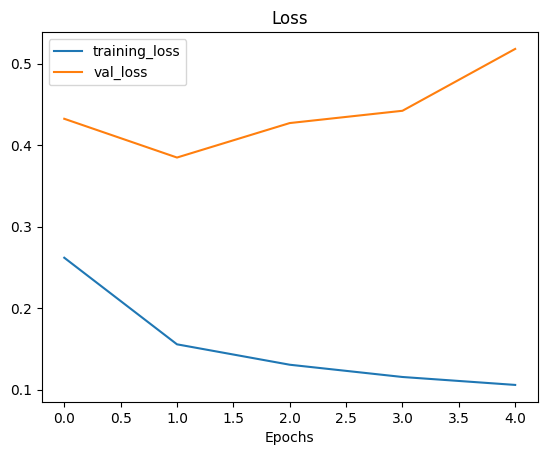

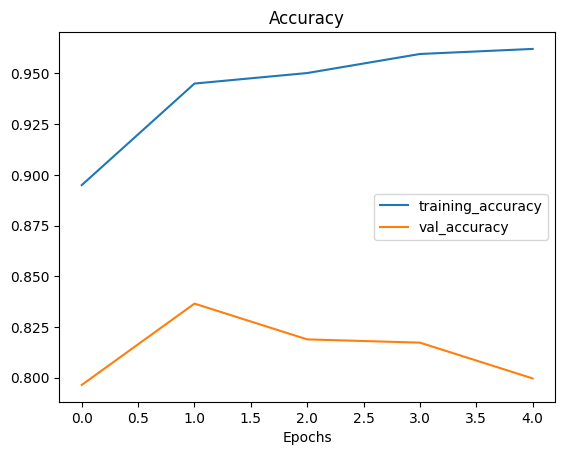

In [89]:
plot_loss_curves(efficient_history)

In [91]:
#LEts evaluate the model
eval_model = efficient_model.evaluate(test_data)

20/20 [==============================] - 7s 302ms/step - loss: 0.5180 - accuracy: 0.7997


I guess , i should optimize my model because of overfitting problem. I think my model was so complicated compared to data . This is my first impression. So that ,  I am gonna use regularization. If it works , thats gonna be good. If it doesnt , i am gonna use data augmentation as a layer into the my model. If it still not be  a good model, i will change the base model (pre-trained model) . After the using feature vector method. I may apply fine tuning .